# Notebook for rereferencing, example with bipolar, CAR and iterable rereference (user defined number of channels).

Use STN-LFP data only, change upper rereference methods for LFP.
Estimate features, plot feature correlation matrix to see differences.
CAR - comon averaging rerefercing

In this notebook we will explore different re-referencing methods and observe how they impact the estimated features. Only STN-LFP data is going to be used, and we will visualize the features for the cases with:

- no re-referencing
- bipolar re-referecing
- CAR -> common averaging re-referencing.

We will also show how the user can set up the list of channels in which respect the re-reference is performed.

In [1]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if SCRIPT_DIR.split("/")[-1] == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_stats
)
from sklearn import metrics, model_selection
import json
import matplotlib.pyplot as plt
import numpy as np
import re

We will use the same data from example_BIDS.ipynb, but we will provide a different path for the output data.

In [3]:
sub = "testsub"
ses = "EphysMedOff"
task = "buttonpress"
run = 0
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = os.path.join(SCRIPT_DIR, "data")

# Provide a path for the output data.
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "default")

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

Extracting parameters from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-testsub/ses-EphysMedOff/ieeg/sub-testsub_ses-EphysMedOff_acq-StimOff_space-mni_electrodes.tsv.


Reference must be either 'default', 'None' or an iterable with the desired re-referencing for each channel. This iterable needs to be the same length as `ch_names`. We start with default, which is what was done in all other examples:

In [4]:
nm_channels_default = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference='default',
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("SQUARED_ROTATION",),
)

In [5]:
stream_default = nm.Stream(
    settings=None,
    nm_channels=nm_channels_default,
    path_grids=None,
    verbose=False,
)

stream_default.set_settings_fast_compute()

stream_default.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_default.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-testsub_ses-EphysMedOff_task-buttonpress_

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png


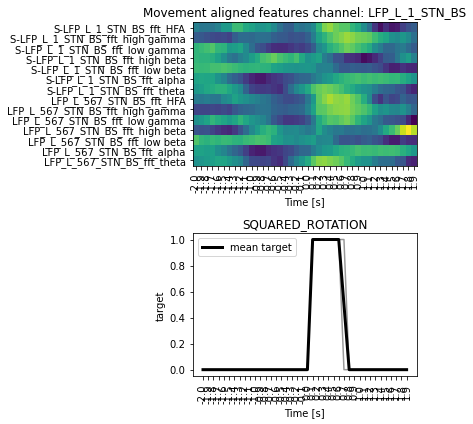

In [6]:
# init analyzer
feature_reader_default = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = feature_reader_default.nm_channels.query(
    '(type=="seeg") and (used == 1)'
).iloc[0]["name"]

feature_used_default = (
    "stft" if feature_reader_default.settings["features"]["stft"] else "fft"
)

feature_reader_default.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used_default],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/rereferencing_example_LFP_avgref.png


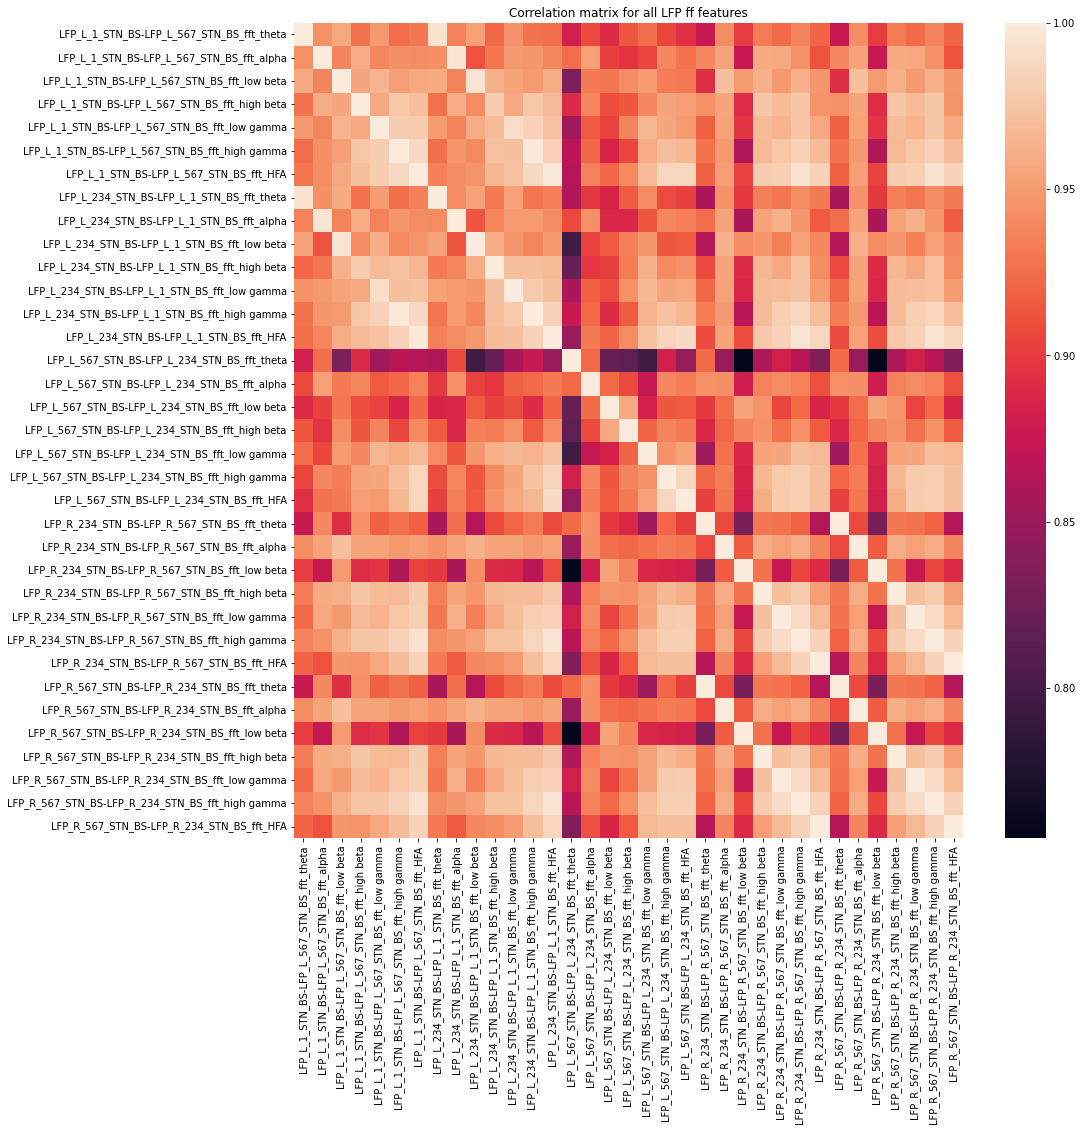

In [7]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_default.feature_arr.filter(regex='LFP'),
        OUT_PATH= PATH_OUT,
        feature_names=feature_reader_default.feature_arr.filter(regex='LFP').columns,
        feature_file=feature_reader_default.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP ff features",
        save_plot_name="rereferencing_example_LFP_avgref.png"
)

## Use common averaging re-reference
As we want to re-reference all LFP channels, but no re-referencing for the rest, we do:

In [8]:
PATH_OUT_avg = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "avg")
ch_names = raw.ch_names
ref = ["average" if "LFP" in item else "None" for item in ch_names]

We need to define the `nm_channels` again and then `stream.run`.

In [9]:
nm_channels_avg = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("SQUARED_ROTATION",),
)
nm_channels_avg

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,None,0,0,ecog,good,ECOG_L_1_SMC_AT
2,ECOG_L_2_SMC_AT,None,0,0,ecog,good,ECOG_L_2_SMC_AT
3,ECOG_L_3_SMC_AT,None,0,0,ecog,good,ECOG_L_3_SMC_AT
4,ECOG_L_4_SMC_AT,None,0,0,ecog,good,ECOG_L_4_SMC_AT
5,ECOG_L_5_SMC_AT,None,0,0,ecog,good,ECOG_L_5_SMC_AT
6,ECOG_L_6_SMC_AT,None,0,0,ecog,good,ECOG_L_6_SMC_AT
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,average,1,0,seeg,good,LFP_L_1_STN_BS-avgref
9,LFP_L_234_STN_BS,average,1,0,seeg,good,LFP_L_234_STN_BS-avgref


In [10]:
stream_avg = nm.Stream(
    settings=None,
    nm_channels=nm_channels_avg,
    path_grids=None,
    verbose=False,
)

stream_avg.set_settings_fast_compute()

stream_avg.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_avg.run(
    data=data,
    out_path_root=PATH_OUT_avg,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/su

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png


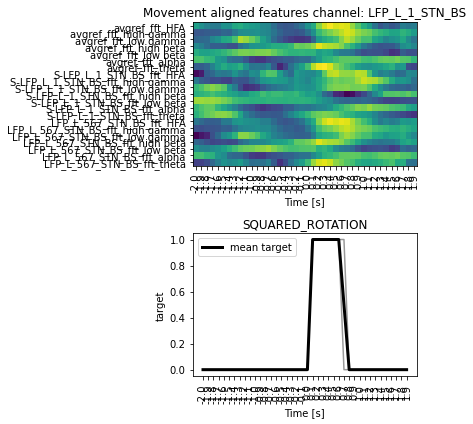

In [11]:
# init analyzer
feature_reader_avg = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_avg, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_avg = feature_reader_avg.nm_channels.query(
    '(type=="seeg") and (used == 1)'
).iloc[0]["name"]

feature_used_avg = (
    "stft" if feature_reader_avg.settings["features"]["stft"] else "fft"
)

feature_reader_avg.plot_target_averaged_channel(
    ch=ch_used_avg,
    list_feature_keywords=[feature_used_avg],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/rereferencing_example_LFP_avgref.png


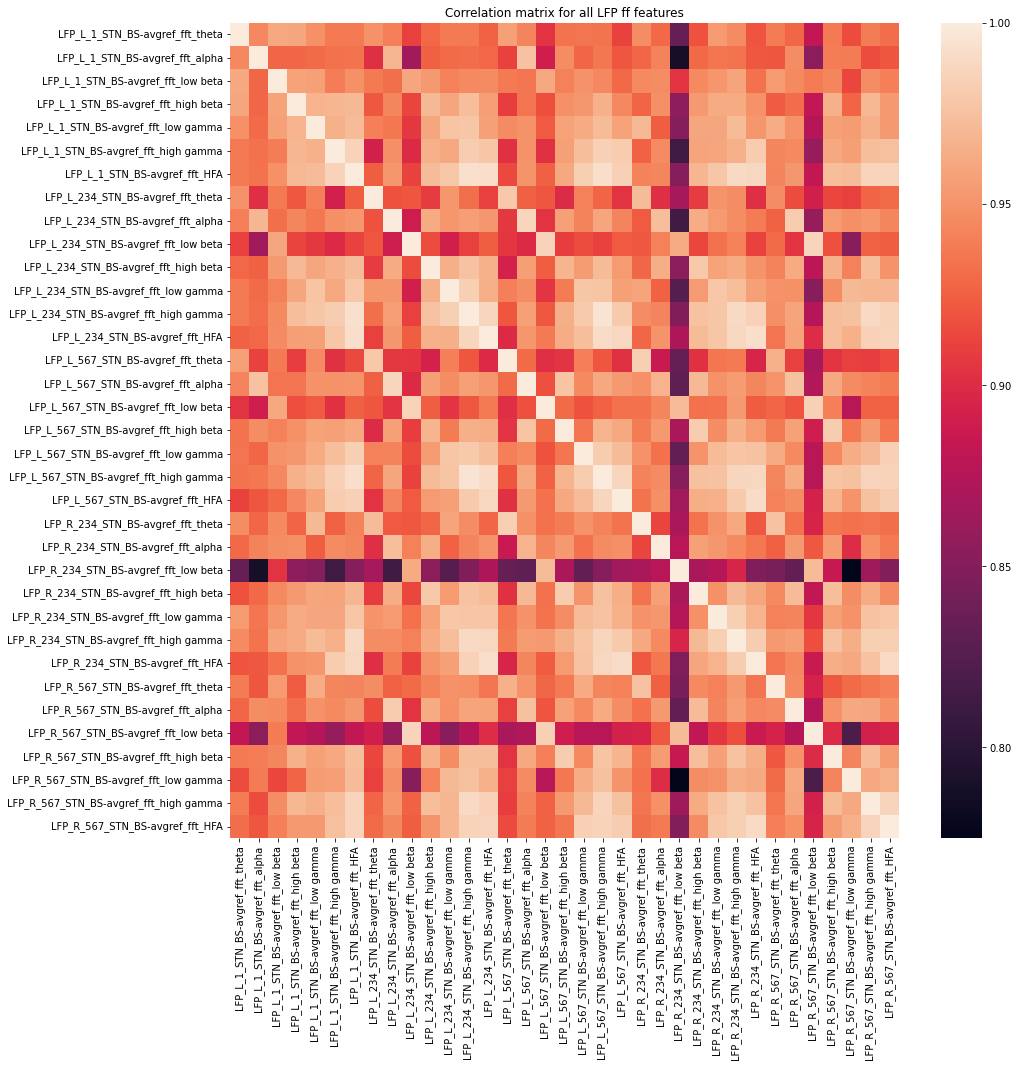

In [12]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_avg.feature_arr.filter(regex='STN_BS-avgref'),
        OUT_PATH= PATH_OUT_avg,
        feature_names=feature_reader_avg.feature_arr.filter(regex='STN_BS-avgref').columns,
        feature_file=feature_reader_avg.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP ff features",
        save_plot_name="rereferencing_example_LFP_avgref.png"
)

## No re-referencing

In [13]:
PATH_OUT_None = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "none")
ch_names = raw.ch_names
ref_None = ["None" if "LFP" in item else "None" for item in ch_names]

We need to define the `nm_channels` again and then `stream.run`.

In [14]:
nm_channels_None = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref_None,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("SQUARED_ROTATION",),
)
nm_channels_None

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,None,0,0,ecog,good,ECOG_L_1_SMC_AT
2,ECOG_L_2_SMC_AT,None,0,0,ecog,good,ECOG_L_2_SMC_AT
3,ECOG_L_3_SMC_AT,None,0,0,ecog,good,ECOG_L_3_SMC_AT
4,ECOG_L_4_SMC_AT,None,0,0,ecog,good,ECOG_L_4_SMC_AT
5,ECOG_L_5_SMC_AT,None,0,0,ecog,good,ECOG_L_5_SMC_AT
6,ECOG_L_6_SMC_AT,None,0,0,ecog,good,ECOG_L_6_SMC_AT
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,None,1,0,seeg,good,LFP_L_1_STN_BS
9,LFP_L_234_STN_BS,None,1,0,seeg,good,LFP_L_234_STN_BS


In [15]:
stream_None = nm.Stream(
    settings=None,
    nm_channels=nm_channels_None,
    path_grids=None,
    verbose=False,
)

stream_None.set_settings_fast_compute()

stream_None.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_None.run(
    data=data,
    out_path_root=PATH_OUT_None,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png


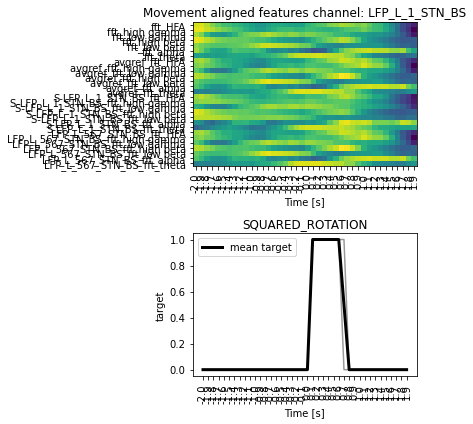

In [16]:
# init analyzer
feature_reader_None = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_None, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_None = feature_reader_None.nm_channels.query(
    '(type=="seeg") and (used == 1)'
).iloc[0]["name"]

feature_used_None = (
    "stft" if feature_reader_None.settings["features"]["stft"] else "fft"
)

feature_reader_None.plot_target_averaged_channel(
    ch=ch_used_None,
    list_feature_keywords=[feature_used_None],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/rereferencing_example_LFP_avgref.png


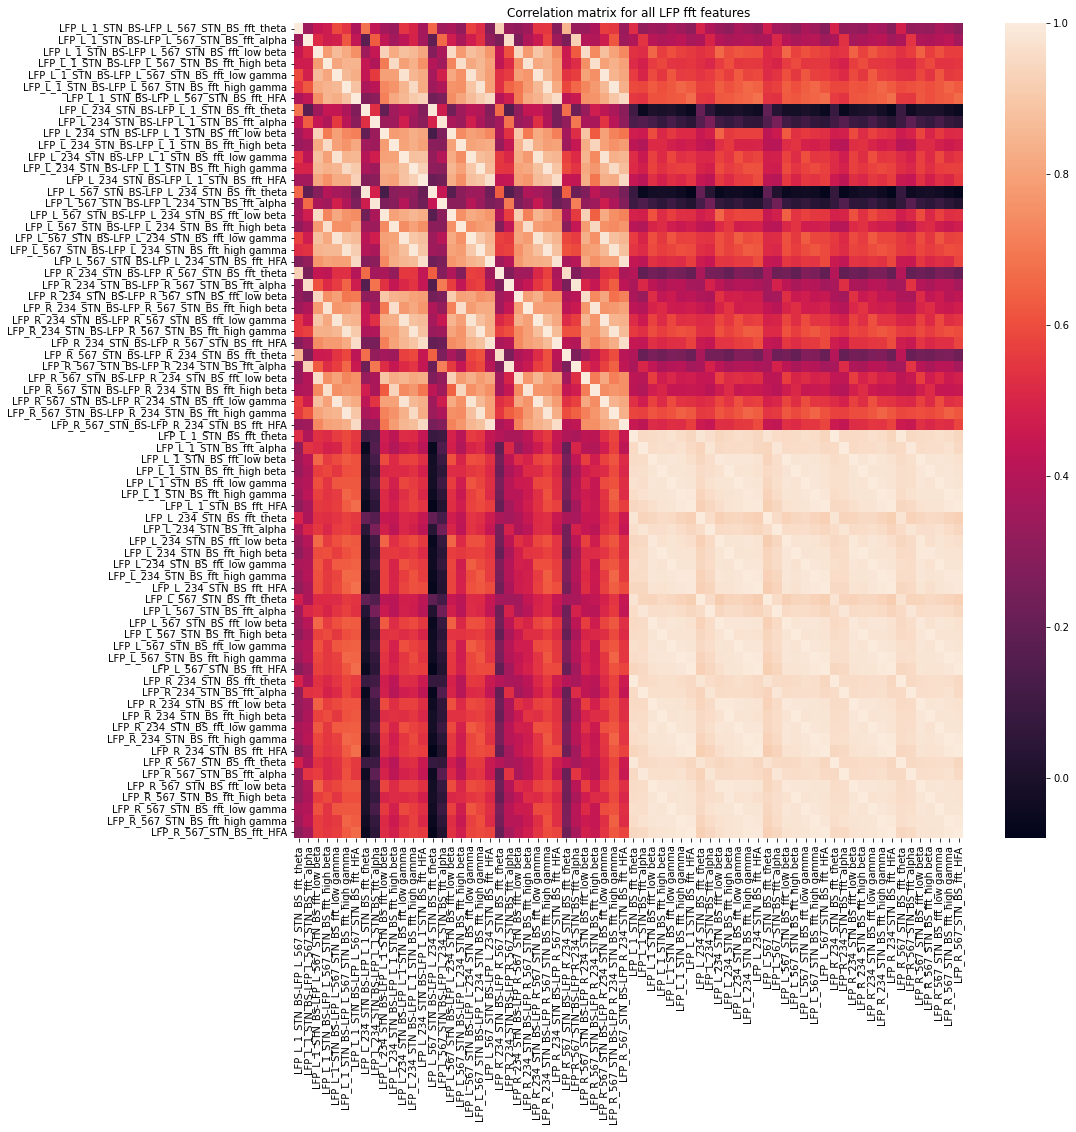

In [17]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_None.feature_arr.filter(regex='STN_BS_fft'),
        OUT_PATH= PATH_OUT_None,
        feature_names=feature_reader_None.feature_arr.filter(regex='STN_BS_fft').columns,
        feature_file=feature_reader_None.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP fft features",
        save_plot_name="rereferencing_example_LFP_avgref.png"
)

## User provided channels for re-referencing

In [18]:
PATH_OUT_userRef = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "userRef")
ref_userRef = ["None","None","None","None","None","None","None","None","LFP_L_2_STN_BS","LFP_L_1_STN_BS","LFP_L_1_STN_BS","LFP_R_1_STN_BS","LFP_R_1_STN_BS","None","None"]

We need to define the `nm_channels` again and then `stream.run`.

In [19]:
nm_channels_userRef = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref_userRef,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("seeg","dbs"),  # We focus only on LFP data
    target_keywords=("SQUARED_ROTATION",),
)
nm_channels_userRef

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,None,0,0,ecog,good,ECOG_L_1_SMC_AT
2,ECOG_L_2_SMC_AT,None,0,0,ecog,good,ECOG_L_2_SMC_AT
3,ECOG_L_3_SMC_AT,None,0,0,ecog,good,ECOG_L_3_SMC_AT
4,ECOG_L_4_SMC_AT,None,0,0,ecog,good,ECOG_L_4_SMC_AT
5,ECOG_L_5_SMC_AT,None,0,0,ecog,good,ECOG_L_5_SMC_AT
6,ECOG_L_6_SMC_AT,None,0,0,ecog,good,ECOG_L_6_SMC_AT
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,LFP_L_2_STN_BS,1,0,seeg,good,LFP_L_1_STN_BS-LFP_L_2_STN_BS
9,LFP_L_234_STN_BS,LFP_L_1_STN_BS,1,0,seeg,good,LFP_L_234_STN_BS-LFP_L_1_STN_BS


In [20]:
stream_userRef = nm.Stream(
    settings=None,
    nm_channels=nm_channels_None,
    path_grids=None,
    verbose=False,
)

stream_userRef.set_settings_fast_compute()

stream_userRef.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_userRef.run(
    data=data,
    out_path_root=PATH_OUT_userRef,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-testsub_ses-EphysMedOff_task-buttonpress_

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/MOV_aligned_features_ch_LFP_L_1_STN_BS_fft.png


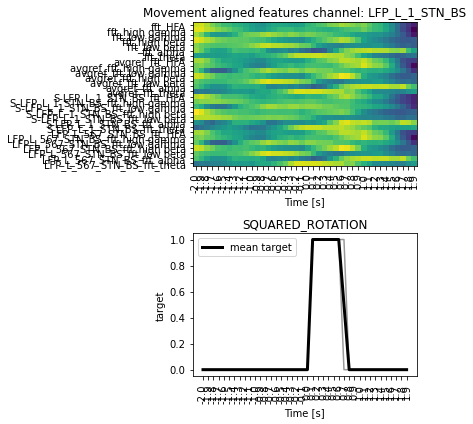

In [21]:
# init analyzer
feature_reader_userRef = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_userRef, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_userRef = feature_reader_userRef.nm_channels.query(
    '(type=="seeg") and (used == 1)'
).iloc[0]["name"]

feature_used_userRef = (
    "stft" if feature_reader_userRef.settings["features"]["stft"] else "fft"
)

feature_reader_userRef.plot_target_averaged_channel(
    ch=ch_used_None,
    list_feature_keywords=[feature_used_None],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/rereferencing_example_LFP_avgref.png


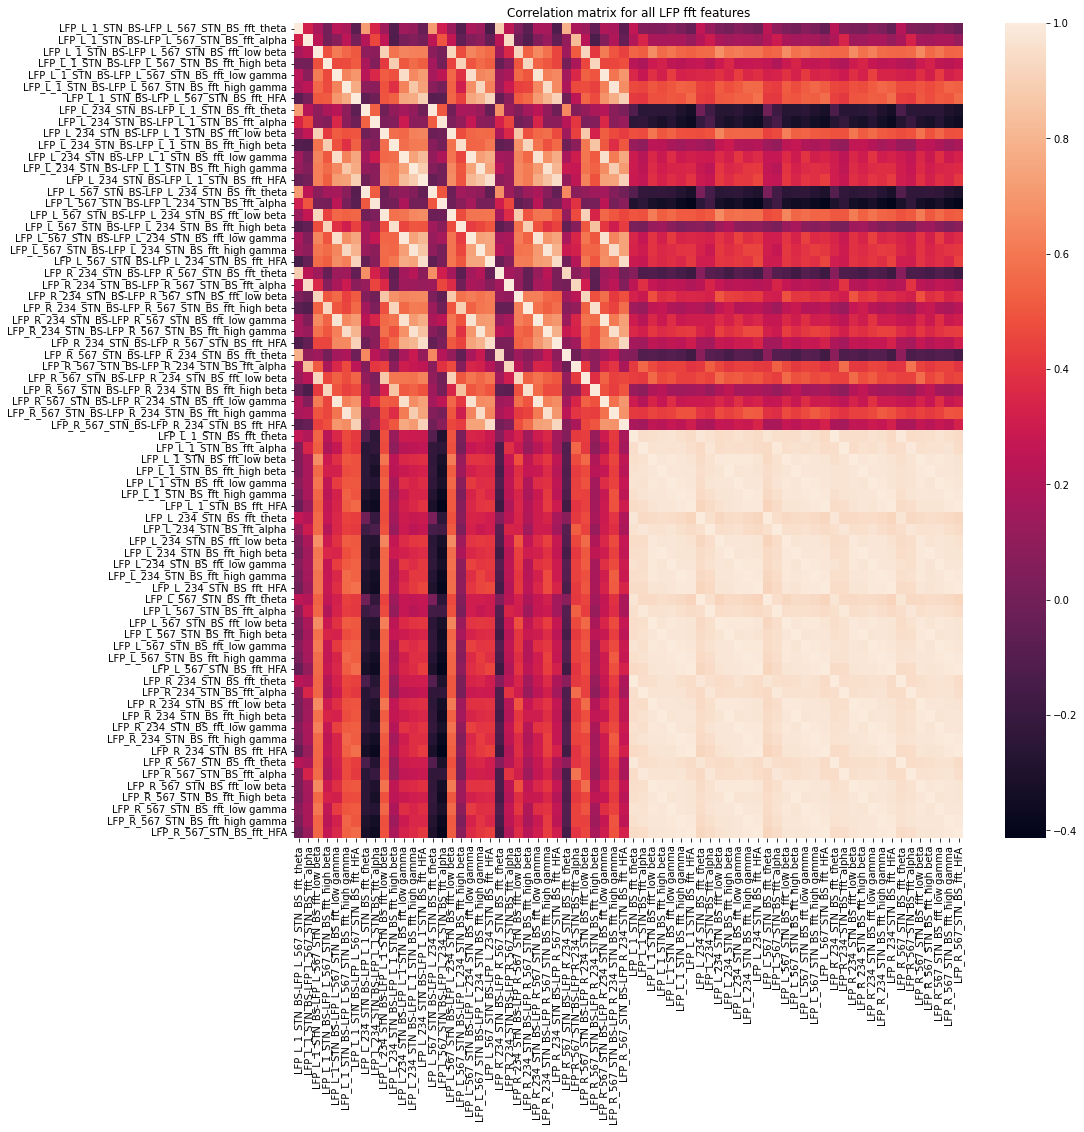

In [22]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_userRef.feature_arr.filter(regex='STN_BS_fft'),
        OUT_PATH= PATH_OUT_userRef,
        feature_names=feature_reader_userRef.feature_arr.filter(regex='STN_BS_fft').columns,
        feature_file=feature_reader_userRef.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP fft features",
        save_plot_name="rereferencing_example_LFP_avgref.png"
)